### Required Setup

If you don't have Python on your computer, you can use the [Anaconda Python distribution](http://continuum.io/downloads) to install most of the Python packages you need. Anaconda provides a simple double-click installer for your convenience.

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

* **NumPy**: Provides a fast numerical array structure and helper functions.
* **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn/sklearn**: The essential Machine Learning package in Python.
* **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: Advanced statistical plotting library.
* **waterqmark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

To make sure you have all of the packages you need, install them with `conda`:

```
conda create -n SYSC4415_tutorials python=3.11
conda activate SYSC4415_tutorials

conda install jupyter
conda install numpy pandas scikit-learn matplotlib seaborn graphviz statsmodels
conda install -c conda-forge watermark

```

`conda` may ask you to update some of them if you don't have the most recent version. Allow it to do so.

**Note:** I will not support people trying to run this notebook outside of the Anaconda Python distribution.


# Tutorial 2-3 - Car Prices & Linear Regression

**Course:** SYSC 4415 - Introduction to Machine Learning

**Semester:** Winter 2025

**Adapted by:** [Kevin Dick](https://kevindick.ai/), [Igor Bogdanov](mailto:igorbogdanov@cmail.carleton.ca)

**Adapted From:** https://sungsoo.github.io/2018/04/11/predicting-car-prices.html

---

In this notebook we will explore the process of:
1. loading tabular data
2. examining raw variables
3. transforming variables
4. exploratory data analysis (EDA)
5. building linear regression model (regression)
6. building a logistic regression model (classification)

This is an example of *predictive analytics* using a dataset that most people can relate to: **prices of a car**!

In the data set, we find the following eight variables:

* *(Int)* Price 
* *(Int)* Age 
* *(Int)* KM (kilometers driven)
* *(String)* Fuel Type
* *(Int)* HP(horsepower)
* *(Bool)* Automatic or Manual
* *(Int)* Number of Doors
* *(Bool)* Metallic Colour
* *(Int)* CC (total volume of air and fuel being pushed through the engine by the cylinders in cubic centimeters)
* *(Int)* Weight(in pounds)

Data for 1,436 vehicles are collected in a CSV file for a single type of vehicle: the _Toyota Corolla_. You can download this dataset from the original author's github account here: https://github.com/datailluminations/PredictingToyotaPricesBlog

### The Target Varriable
In **predictive models**, there is a response variable (also called dependent variable or **target variable**), which is the variable that we are interested in predicting.

### The Features
The **independent variables** (the predictors, also called **features** in the machine learning community) are one or more numeric variables we are using to predict the response variable. Given we are using a linear regression model, we are assuming the relationship between the independent and dependent variables follow a straight line. Later, one could examine more complex models to see if it improves predictive powers.

# 1. Loading Tabular Data

In [2]:
# First load up any packages we will need!
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import seaborn as sb

import pandas.testing as tm

# to verify what we are using
import sys 
print(sys.executable)  
print(sys.version) 

/opt/homebrew/anaconda3/envs/SYSC4415_tutorials/bin/python
3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]


Note: If you are missing certain packages, you can use **pip** within the command line to install them!
If using Google's Colab, you can use a cell with a leading exclamation point to execute shell commands. For example: 
`!pip install pandas`

In [6]:
# data source & load into a dataframe
file = 'https://raw.githubusercontent.com/datailluminations/PredictingToyotaPricesBlog/master/ToyotaCorolla.csv'
car_data = pd.read_csv(file)

# set the column headers
df = pd.DataFrame(car_data, columns= ['Price', 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'])

# (optional) unpack columns into individual variables
price     = df['Price']
age       = df['Age']
km        = df['KM']
fuelType  = df['FuelType']
hp        = df['HP']
metColor  = df['MetColor']
automatic = df['Automatic']
cc        = df['CC']
doors     = df['Doors']
weight    = df['Weight']

df.head()

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165
3,14950,26,48000,Diesel,90,0,0,2000,3,1165
4,13750,30,38500,Diesel,90,0,0,2000,3,1170


# 2. Examine Raw Variables

Before we start the modeling exercise, it’s good to take a visual look at what we are trying to predict to see what it looks like. Since we are **trying to predict Toyota Corolla prices with historical data**, we can create simple histogram plots to examine the distribution of Corolla prices (or another variable of our choosing):

In [8]:
# We can also examine the summary statistics for each feature (note that categorical features aren't present)
df.describe()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000
mean,10730.824513,55.947075,68533.259749,101.502089,0.674791,0.055710,1566.827994,4.033426,1072.45961
std,3626.964585,18.599988,37506.448872,14.981080,0.468616,0.229441,187.182436,0.952677,52.64112
min,4350.000000,1.000000,1.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,1000.00000
25%,8450.000000,44.000000,43000.000000,90.000000,0.000000,0.000000,1400.000000,3.000000,1040.00000
50%,9900.000000,61.000000,63389.500000,110.000000,1.000000,0.000000,1600.000000,4.000000,1070.00000
75%,11950.000000,70.000000,87020.750000,110.000000,1.000000,0.000000,1600.000000,5.000000,1085.00000
max,32500.000000,80.000000,243000.000000,192.000000,1.000000,1.000000,2000.000000,5.000000,1615.00000


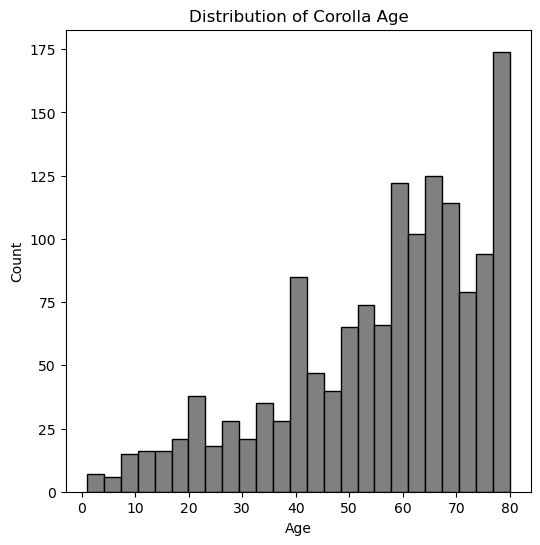

In [9]:
# Change this variable to the one we are interested in plotting (why does FuelType throw an error?)
var2plot = 'Age' # 'Price', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'

plt.figure(figsize= (6,6))
plt.hist(df[var2plot], bins=25, color= 'grey', edgecolor= 'black')
plt.xlabel(var2plot)
plt.ylabel("Count")
plt.title(f"Distribution of Corolla {var2plot}")
plt.show()

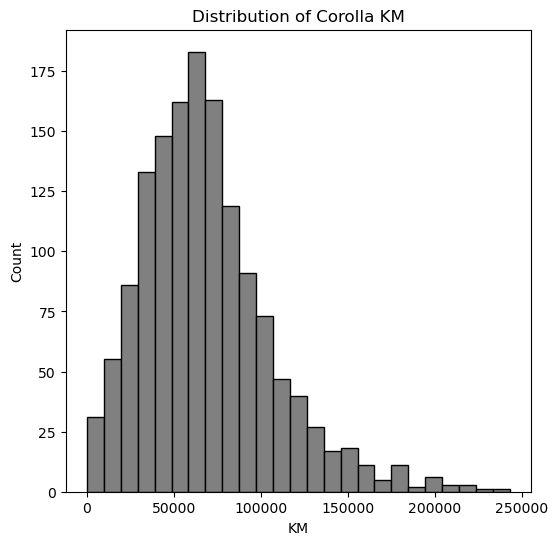

In [10]:
# Change this variable to the one we are interested in plotting (why does FuelType throw an error?)
var2plot = 'KM' # 'Price', 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'

plt.figure(figsize= (6,6))
plt.hist(df[var2plot], bins=25, color= 'grey', edgecolor= 'black')
plt.xlabel(var2plot)
plt.ylabel("Count")
plt.title(f"Distribution of Corolla {var2plot}")
plt.show()

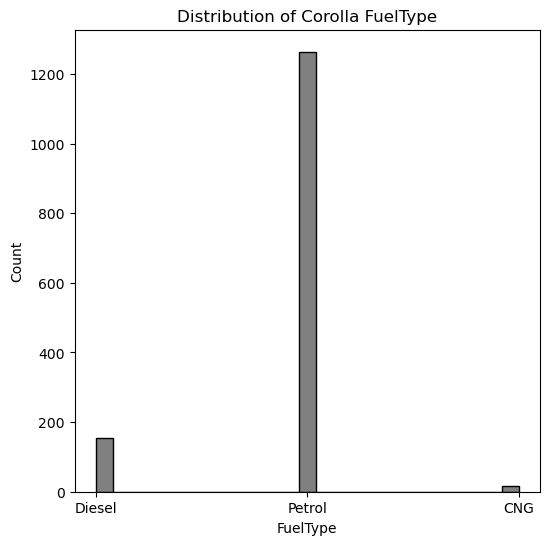

In [12]:
# Change this variable to the one we are interested in plotting (why does FuelType throw an error?)
var2plot = 'FuelType' # 'Price', 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'

plt.figure(figsize= (6,6))
plt.hist(df[var2plot], bins=25, color= 'grey', edgecolor= 'black')
plt.xlabel(var2plot)
plt.ylabel("Count")
plt.title(f"Distribution of Corolla {var2plot}")
plt.show()

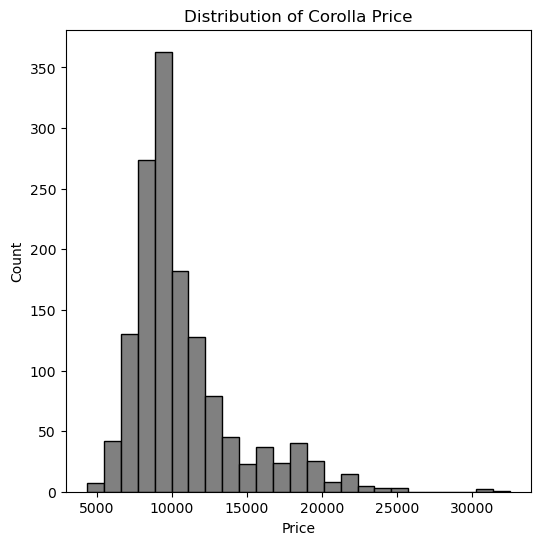

In [13]:
# Change this variable to the one we are interested in plotting (why does FuelType throw an error?)
var2plot = 'Price' # 'Age', 'KM', 'FuelType', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'

plt.figure(figsize= (6,6))
plt.hist(df[var2plot], bins=25, color= 'grey', edgecolor= 'black')
plt.xlabel(var2plot)
plt.ylabel("Count")
plt.title(f"Distribution of Corolla {var2plot}")
plt.show()

We see that most used Corollas cost around 10K and there are some at the tail end that over 25K (possibly newer cars).

# 3. Data Transformation

One of the main steps in the predictive analytics is data transformation. Data is **seldom arranged in the way you want them**. 

One might have to do some kinds of transformations to get it to the way we need them to be either because the data is dirty, not of the type we want, out of bounds, and a host of other reasons.

### Catagorical Variable --> Numerical Variable
In this case, we need to convert the categorical variables to numeric variables to feed into our linear regression model, because **linear regression models only take numeric variables**.

The categorical variable we want to do the transformation on is **Fuel Types**. We note that there are 3 Fuel Types:
1. CNG 
2. Diesel 
3. Petrol

Let's first count how many there are of each and then encode this into a numerical format!

In [15]:
# print out all of the unique fuelType categories
print(fuelType.unique())

# count the number of instances of each (summation of the subset for each; a value of 1 for each TRUE instance)
num_cng    = np.sum(fuelType == "CNG")
num_diesel = np.sum(fuelType == "Diesel")
num_petrol = np.sum(fuelType == "Petrol")
print(f"CNG:\t{num_cng}\nDiesel:\t{num_diesel}\nPetrol:\t{num_petrol}")

['Diesel' 'Petrol' 'CNG']
CNG:	17
Diesel:	155
Petrol:	1264


So, we can convert the categorical variable Fuel Type to *two numeric variables*: **FuelType1** and **FuelType2**. 

We assign CNG to a new variable FuelType1 in which a 1 represents it’s a CNG vehicle and 0 it’s not. 
Likewise, we assign Diesel to a new variable FuelType2 in which a 1 represents it’s a Diesel vehicle and 0 it’s not.

So, what do we do with PETROL vehicles? We could have introduced a third varialbe (e.g. FuelType3), but here we will represent PETROL by the case when BOTH FuelType1 and FuelType2 are zero.

In [16]:
# convert categorical variables to integer so we can use in our model
fuelType1 = (fuelType == "CNG")* 1  # multiple by 1 to ensure numeric representation True* 1 = 1, False* 1= 0
fuelType2 = (fuelType == "Diesel")* 1

# Add these new variables to our DataFrame
df["FuelType1"] = fuelType1
df["FuelType2"] = fuelType2

print(df.head().to_string())

   Price  Age     KM FuelType  HP  MetColor  Automatic    CC  Doors  Weight  FuelType1  FuelType2
0  13500   23  46986   Diesel  90         1          0  2000      3    1165          0          1
1  13750   23  72937   Diesel  90         1          0  2000      3    1165          0          1
2  13950   24  41711   Diesel  90         1          0  2000      3    1165          0          1
3  14950   26  48000   Diesel  90         0          0  2000      3    1165          0          1
4  13750   30  38500   Diesel  90         0          0  2000      3    1170          0          1


# 4. Exploratory Data Analysis (EDA):

The next step in predictive analytics is to explore our underlying data structure. 

Let’s do a few plots of our explantory variables to see how they look against `Price`.

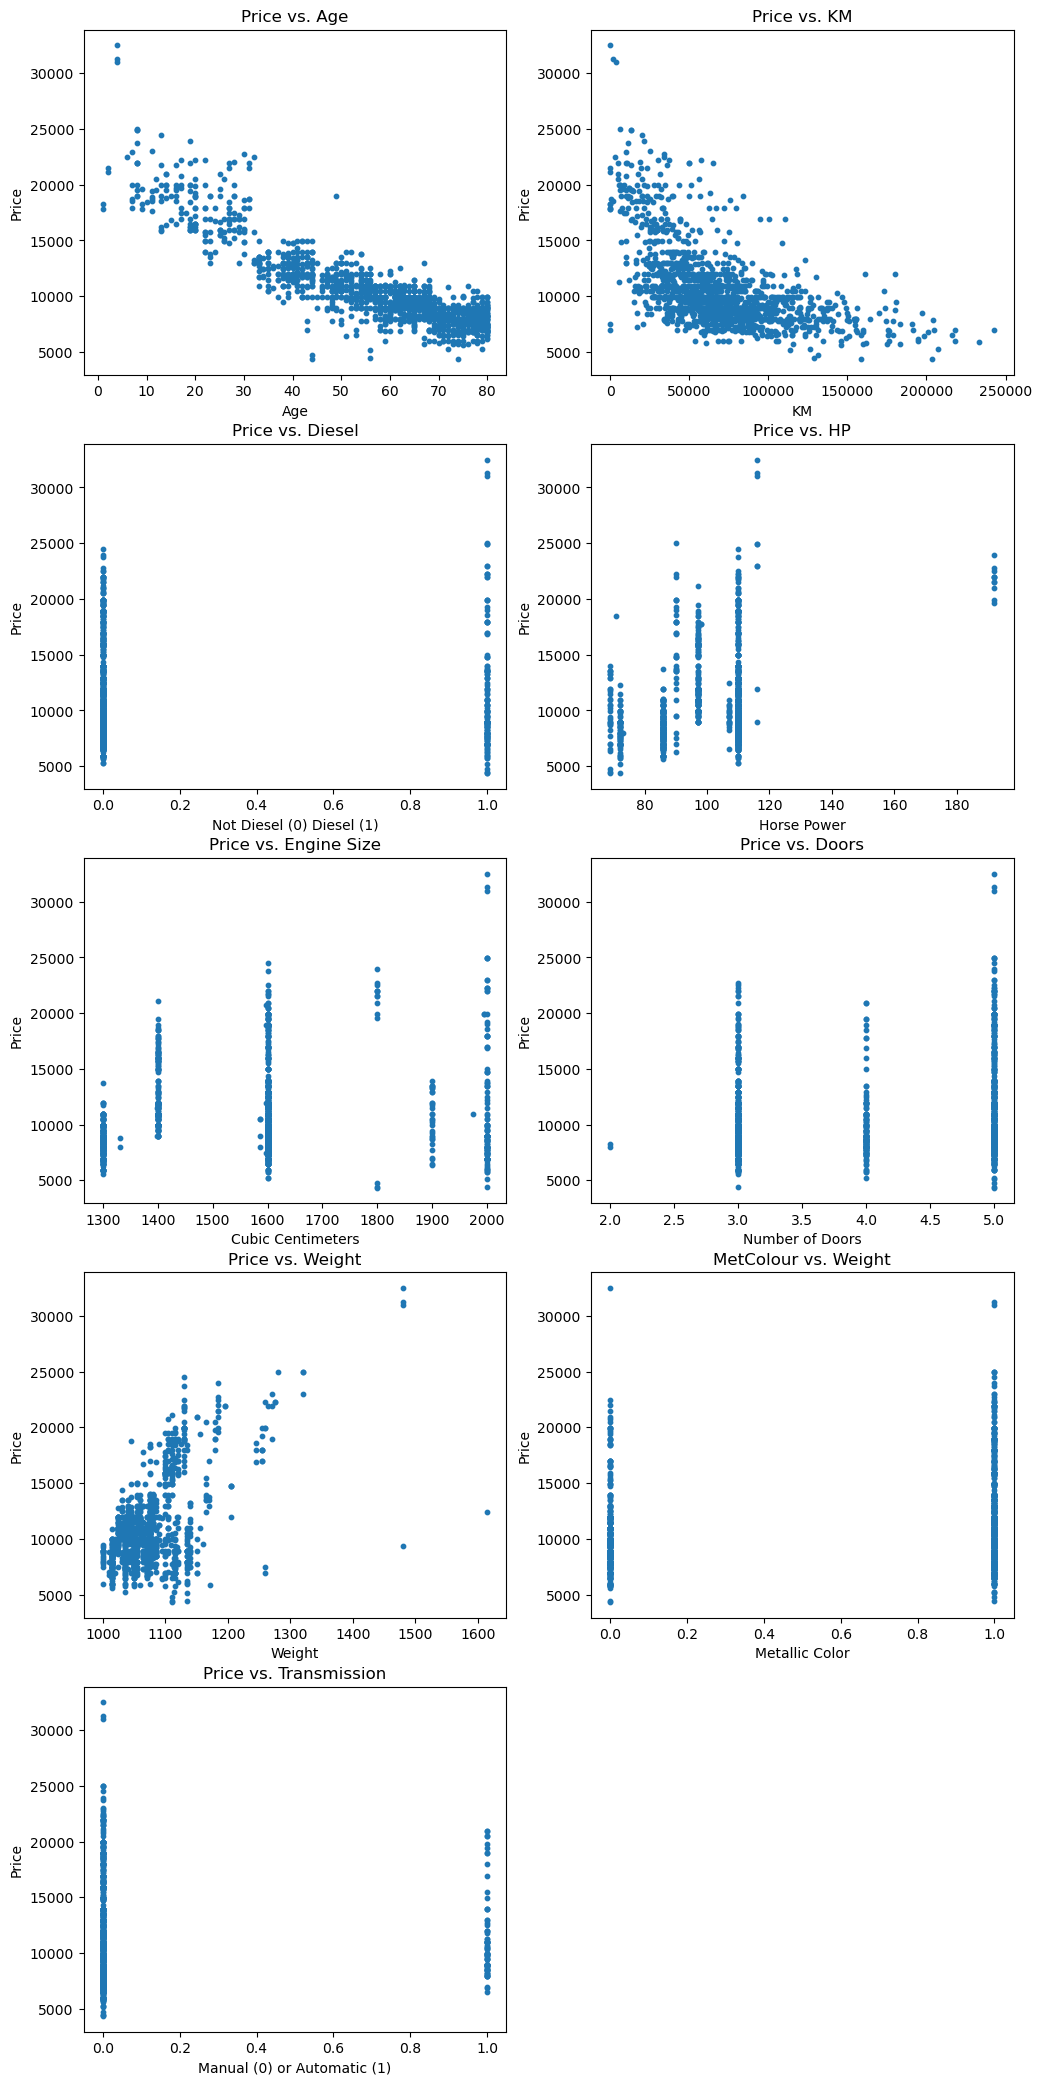

In [17]:
# plot variables against price
plt.figure(figsize= (12,26))

plt.subplot(5, 2, 1); plt.scatter(age, price, s=10); plt.xlabel("Age"); plt.ylabel("Price"); plt.title("Price vs. Age")
plt.subplot(5, 2, 2); plt.scatter(km, price, s=10); plt.xlabel("KM"); plt.ylabel("Price"); plt.title("Price vs. KM")
plt.subplot(5, 2, 3); plt.scatter(fuelType2, price, s=10); plt.xlabel("Not Diesel (0) Diesel (1)"); plt.ylabel("Price"); plt.title("Price vs. Diesel")
plt.subplot(5, 2, 4); plt.scatter(hp, price, s=10); plt.xlabel("Horse Power"); plt.ylabel("Price"); plt.title("Price vs. HP")
plt.subplot(5, 2, 5); plt.scatter(cc, price, s=10); plt.xlabel("Cubic Centimeters"); plt.ylabel("Price"); plt.title("Price vs. Engine Size")
plt.subplot(5, 2, 6); plt.scatter(doors, price, s=10); plt.xlabel("Number of Doors"); plt.ylabel("Price"); plt.title("Price vs. Doors")
plt.subplot(5, 2, 7); plt.scatter(weight, price, s=10); plt.xlabel("Weight"); plt.ylabel("Price"); plt.title("Price vs. Weight")
plt.subplot(5, 2, 8); plt.scatter(metColor, price, s=10); plt.xlabel("Metallic Color"); plt.ylabel("Price"); plt.title("MetColour vs. Weight")
plt.subplot(5, 2, 9); plt.scatter(automatic, price, s=10); plt.xlabel("Manual (0) or Automatic (1)"); plt.ylabel("Price"); plt.title("Price vs. Transmission")
plt.show()

From these plots, we can obtain a few insights: 

* (Age) **Newer cars** tend to be **more expensive** (as expected)
* (KM) The **more miles** a car has the **cheaper** it is.
* (HP) Horsepower - this one is not as direct as the other. Yes, the more horsepower the more expensive. But not always the case. Let’s see how this variable will behave in our model.
* (Metcolor) The fact that a color has a **Metallic Color** or not **doesn’t seem to be that useful**. But let’s see what the model says...
* (automatic) **Transmission type** does not have much of an influence on the **prices**.
* (CC) The **engine size** plots against price seems to show the **larger engines** tend to be **more expensive** though not always the case.
* (doors) Plotting number of doors does not tell us much.
* (weight) The heavier(i.e. bigger) cars cost more though there are some outliers that doesn’t fit nicely.

When working on a new problem with tabular data, the insights from Exploratory Data Analysis (EDA) help in building a "story" about the data and develop an intuition for how certain variables relate to others.

# 5. Model Building - Linear Regression

Now that we have explored our variables, let’s perform a simple linear regression of `Price` against all the data we’ve collected.

In [23]:
# setup foor a linear regression (we MUST remove the dependent variable from the features)
x  = df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']] # features/independent variables
x  = sm.add_constant(x)   # Recall that sm is 'statsmodels.api'
y1 = df['Price']        # our dependent variable

# fit our linear regression model
model1 = sm.OLS(y1, x).fit()   # using Ordinary Least Squares 

# apply trained/learned model back to training data
pred1 = model1.predict(x)  

# print summary stats from model fit
print(model1.summary())  

# The predictions are listed in pred1 in order
print(pred1)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     948.0
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:04:13   Log-Likelihood:                -12346.
No. Observations:                1436   AIC:                         2.471e+04
Df Residuals:                    1425   BIC:                         2.477e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2680.6851   1219.030     -2.199      0.0

### Model Interpretation

We see from the output that our model captures **86.9% (see Multiple R square) of the variation** in `price` using the explantory variables above. This is pretty decent.

However, we notice is that **some coefficents are more statistically significant than others**. 

For example, we find that `Age` is the **most significant** witha t-value of -46.889, followed by `Weight` with a t-value of 16.629. 

The **least significant variables** are `Metallic Color` and `Number of Doors`. This was also confirmed in our EDA (exploratory data analysis) graphs above.

### Correcting the Data Split
Now, it’s generally **NOT a good idea to use your ENTIRE data sample to fit the model**. 

What we want to do is to **train the model on a sample of the data**. 
Then we’ll **see how it perform outside of our training sample**. 

This breaking up of our data set into a **training set** and **test set** to evaluate the performance of our models with _unseen data_. Using the entire data set to build a model then using the entire data set to evaluate how good a model does is a bit of cheating or careless analytics.

### Results with Training Data:

Here we will use the first 1,000 rows (of 1,436 iinstances; ~2/3) as our training set:

In [24]:
x  = df[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']]
y1 = df['Price']

# take first 1000 samples of independent variables as training set
trainX = x[0:1000]  
trainX = sm.add_constant(trainX) # add constant
trainY = y1[0:1000] # take first 1000 samples of price as well as training set

# Train model on training data
model2 = sm.OLS(trainY, trainX).fit()
trainingResults = model2.predict(trainX) # Evaluate model on training set
 
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     628.8
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:04:16   Log-Likelihood:                -8649.8
No. Observations:                1000   AIC:                         1.732e+04
Df Residuals:                     989   BIC:                         1.738e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2916.5288   1447.024     -2.016      0.0

### Model Interpretation

Interesting enough, the **R-squared only changed nominally to 86.4%** and the variables **t-value also moved slightly**. The **statistically significant relationships remained the same**. Good1

### Model Evaluation: Linear Regression

The real test of a good model is to **test the model with data that it has not been fitted**. Here’s where the rubber meets the road. We apply our model to unseen data to see how it performs.

### Prediction using out-of-sample data

Here are some common metrics to see how well the model predicts using various error metrics. 
The main takeway is we **want our forecast errors to be as small as possible**. The smaller the forecast error the better the model is at predicting unseen data.

#### Metric 1: Mean Absolute Error (MAE)
The first metric is **mean absolute error (MAE)**: the average absolute value of the error observed over all test points. The smaller the better!

$\left ( \frac{1}{n} \right) \sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}}\right |$

In [25]:
testX= x[1000:]  # take the remaining samples of independent variables for testing set
testX = sm.add_constant(testX) # add constant
testY= y1[1000:] # take the remaining samples of price as well for testing set

testingResults = model2.predict(testX) # results of trained model on new data
#print(testingResults)

# mean absolute error
mae = sm.tools.eval_measures.meanabs(testY, testingResults)
print("mean absolute error: %.2f" % mae)

mean absolute error: 988.87


The **ideal MAE is zero**, which means on average the **predicted value perfectly matches the actual value**. This is rarely if ever the case. 

As in all things, we must determine what is an acceptable level of errors for our predictive analytics model and accept it. No such thing as a perfect model!

#### Metric 2: Root Mean Squared Error (RMSE)
The second metric is **root mean squared error (RMSE)**: the average of the squared differences between the predicted value and the actual value. 

The reason we square is to not account for sign differences(negative differences and positive differences are the same thing when squared). RMSE brings it back to our normal unit by taking the square root of MSE.

$ \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big( y_i - \hat{y_i}\Big)^2}}$

In [26]:
# root mean squared error
rmse= sm.tools.eval_measures.rmse(testY, testingResults)
print("root mean squared error: %.2f" % rmse)

root mean squared error: 1260.63


#### Metric 3: Mean Absolute Percent Error

The third metric is **mean absolute percent error (MAPE)**: expresses the forecasted errors as a percentage. 

$\displaystyle\frac{100\%}{n}\sum_{i=1}^{n}\left |\frac{y_i - \hat{y_i}}{y_ii}\right|$

In [27]:
# mean absolute percent error
mape= np.mean(np.abs((testY - testingResults) / testY)) * 100
print('mean absolute percent error: %.2f' % mape)

mean absolute percent error: 12.18


On average, our model had a forecast error of only 12.2%. Not bad for a first pass at this data set.

# 6. Model Building - Logistic Regression

Now let's say we want to use this data to create a model that will **predict whether or not we can afford a car** from the variables we have discussed. 

**Assume:** We have 10,000 dollars to spend. 

We **use the budget of 10,000 dollars as a trheshold criteria for assigning cars a class**:
1. (class 1) we can afford the car (<= 10,000) 
2. (class 0) we cannot afford the car

Let's prepare the data for this **binary classification** task.

In [35]:
# logistic regression for afford/ cannot afford
# we are building dataset to use for training

df2 = df.drop(columns=['FuelType']) # make a copy of df to use in logistic regression (get rid of the non-numeric FuelType)
cash_on_hand = 10000 # what we can afford

#price is the variable that stores columns from before

price2 = (price <= cash_on_hand) * 1 # create array of logical class labels based on whether or not we can afford

df2["Price"] = price2 # update price with class labels

print(df2.head().to_string())

   Price  Age     KM  HP  MetColor  Automatic    CC  Doors  Weight  FuelType1  FuelType2
0      0   23  46986  90         1          0  2000      3    1165          0          1
1      0   23  72937  90         1          0  2000      3    1165          0          1
2      0   24  41711  90         1          0  2000      3    1165          0          1
3      0   26  48000  90         0          0  2000      3    1165          0          1
4      0   30  38500  90         0          0  2000      3    1170          0          1


Great, now we have a binary classification problem! 
Let's start by plotting how many of each class there are.

Text(0, 0.5, 'Count')

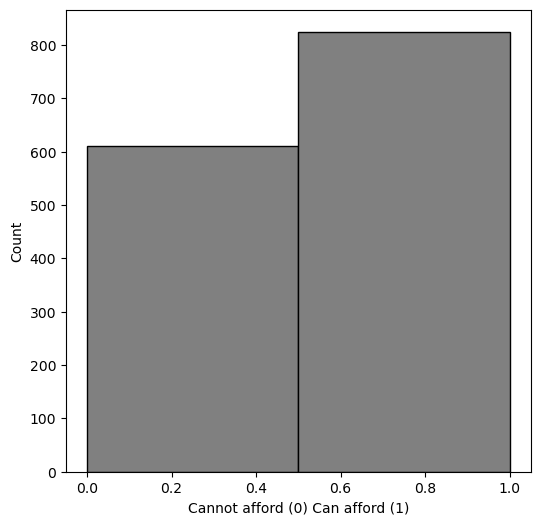

In [33]:
plt.figure(figsize= (6,6))
plt.hist(price2, bins=2, color= 'grey', edgecolor= 'black'); plt.xlabel("Cannot afford (0) Can afford (1)"); plt.ylabel("Count")

Okay, great - these two classes look relatively equal in size. 

### Class Balance
Visualizing the class distribution is a good first step, because you can check for class imbalance and get an indication of how to read your classifier's accuracy. **If our two classes were split 50/50 (0/1) and we scored a classification accuracy of 50%, then we know that our classifier is no better than a coin toss (random chance)**. 

If the classes were split 90/10 (0/1) and we got the same accuracy, then we would know that our classifier was better than random.

### Visualizing Features

Now let's look at our data again. When we visualized our data in the linear regression model, we were **looking for variables that formed a _linear trend_ with price**. 

Now in the logistic regression, we are **looking for features that _separate our two classes_ into two groups**. The greater the separation of the distributions, the better the feature.

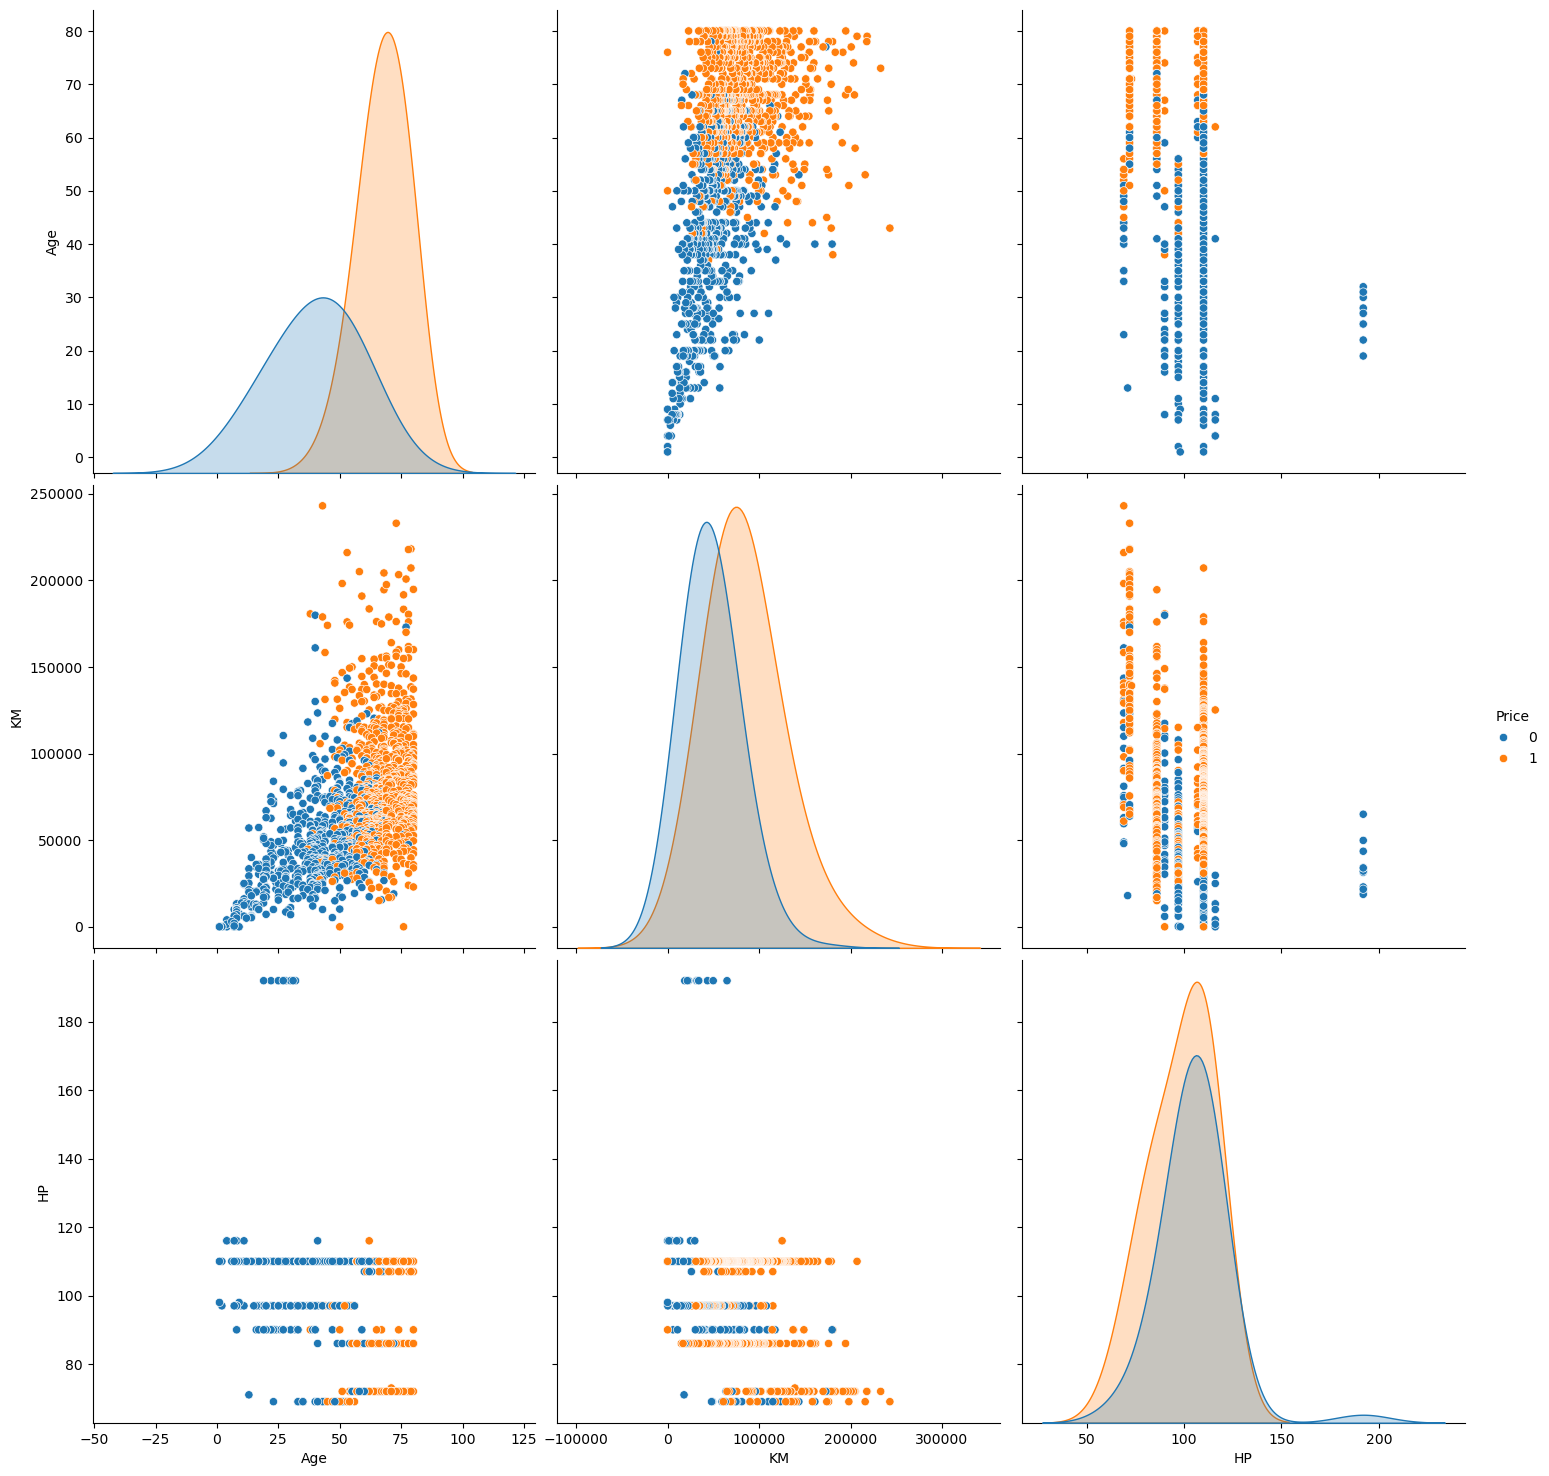

In [46]:
# ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
# ['Age', 'KM', 'HP', ]

df2_scater1 = df2.drop(columns=['MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2'])

# Pair plots are an effectiive way to visualize all combinatioins of features
sb.pairplot(df2_scater1, hue='Price', height= 5, diag_kws={'bw_method': 0.9})
plt.show()
# NOTE (F20): statsmodels==0.11.1,seaborn==0.10.0, requires specification of a float value for the KDE bandwidth for the diagonal

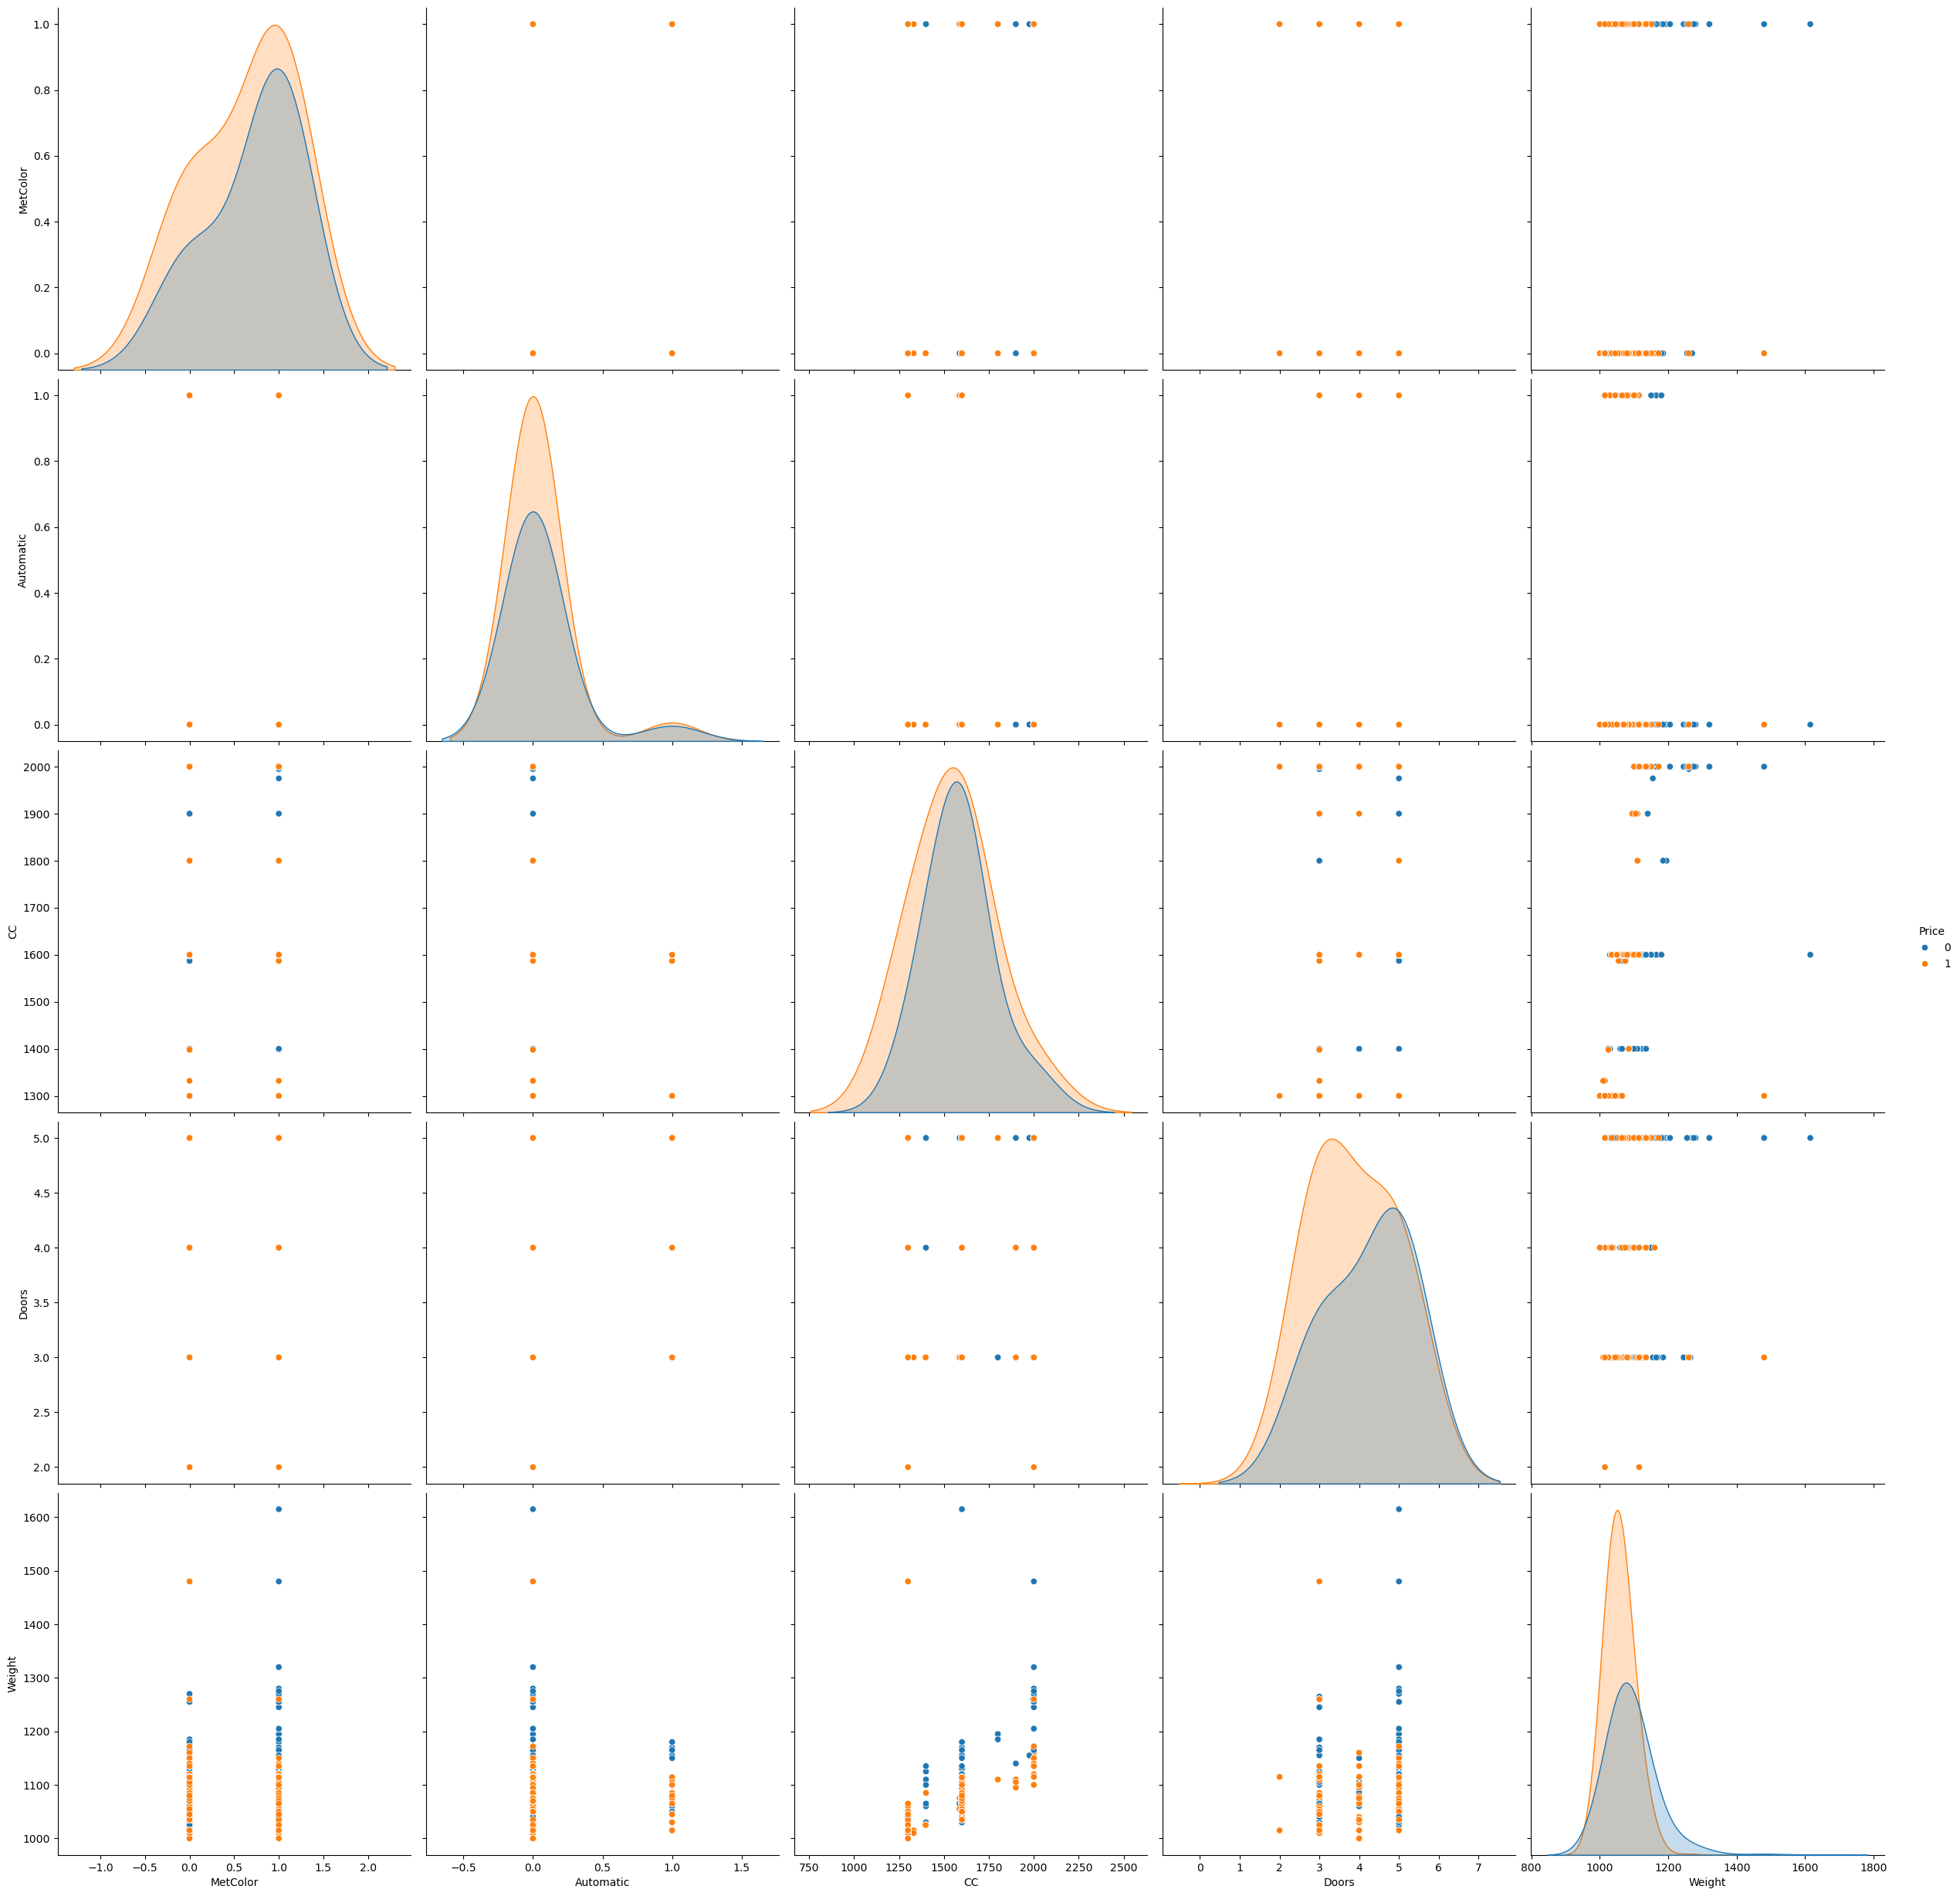

In [47]:
# ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
# ['Age', 'KM', 'HP', ]
df2_scater2 = df2.drop(columns=['Age', 'KM', 'HP', 'FuelType1', 'FuelType2'])

# Pair plots are an effectiive way to visualize all combinatioins of features
sb.pairplot(df2_scater2, hue='Price', height= 5, diag_kws={'bw_method': 0.9})
plt.show()
# NOTE (F20): statsmodels==0.11.1,seaborn==0.10.0, requires specification of a float value for the KDE bandwidth for the diagonal

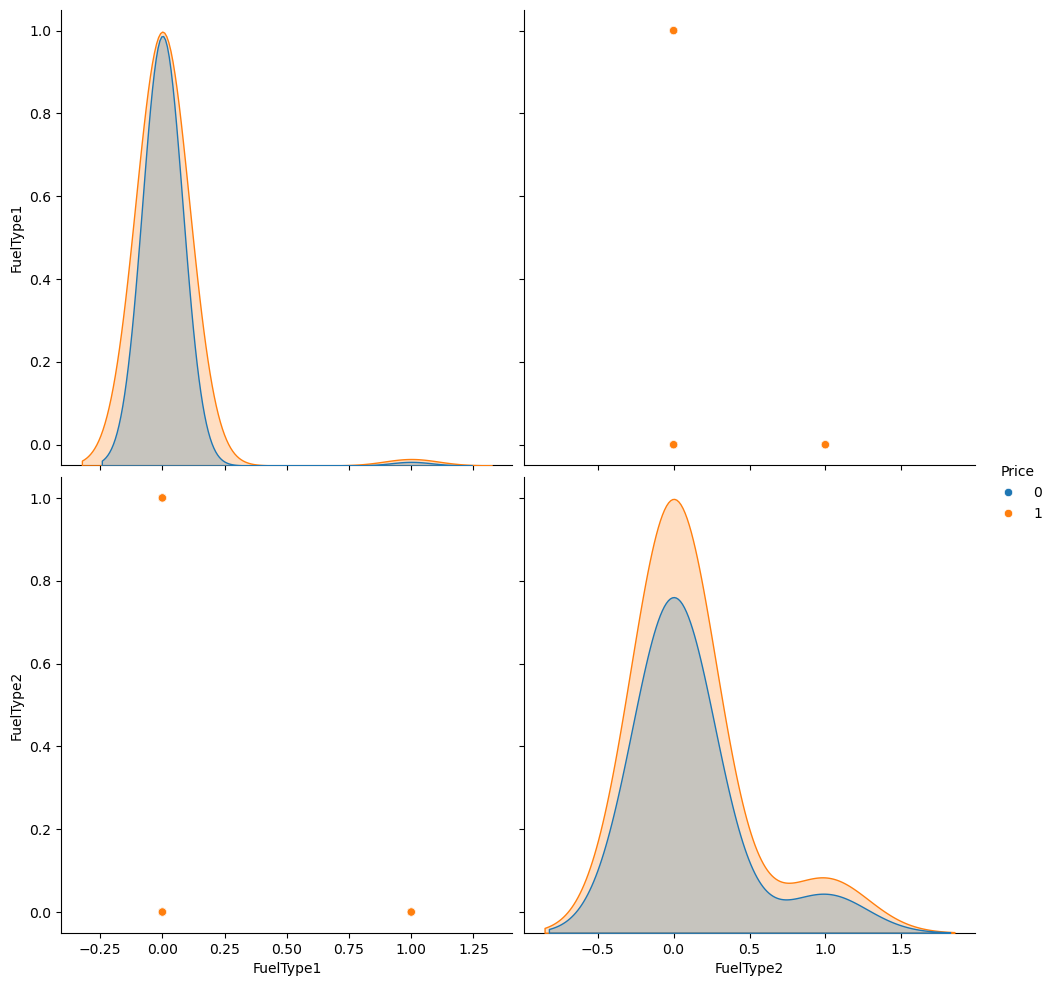

In [48]:
# ['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight']
# ['Age', 'KM', 'HP', ]
df2_scater2 = df2.drop(columns=['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight'])

# Pair plots are an effectiive way to visualize all combinatioins of features
sb.pairplot(df2_scater2, hue='Price', height= 5, diag_kws={'bw_method': 0.9})
plt.show()
# NOTE (F20): statsmodels==0.11.1,seaborn==0.10.0, requires specification of a float value for the KDE bandwidth for the diagonal

These plots tell us that cars in class 1 tend to be: 

* older,
* have higher km,
* and have lower horsepower.

These plots also tell us, as they did in the linear regression, that `metallic color`, `transmission type`, `number of cyclinders`, `number of doors`, `weight`, and `fuel type` do not distinguish these two classes very well.

### Creating a Logistic Regression Model

Let's see what we get when we build a logistic regression classifier using these features. We'll start by making a **training data set using 70% of our data** and a **test data set using the remaining 30%** of the data.

In [49]:
x = df2[['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1', 'FuelType2']]
y = df2['Price']

# Partition training and testing data sets
samples    = x.shape[0]       # returns number of samples
szTraining = int(samples*0.7) # 70% rounded to the nearest integer
trainX     = x[0:szTraining]
trainY     = y[0:szTraining]
testX      = x[szTraining:]
testY      = y[szTraining:]

# Construct model using all features
logitModel = sm.Logit(trainY,trainX)
result     = logitModel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.301692
         Iterations 9
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: Price            Pseudo R-squared: 0.556      
Date:               2025-01-23 12:25 AIC:              626.4002   
No. Observations:   1005             BIC:              675.5277   
Df Model:           9                Log-Likelihood:   -303.20    
Df Residuals:       995              LL-Null:          -682.34    
Converged:          1.0000           LLR p-value:      2.0307e-157
No. Iterations:     9.0000           Scale:            1.0000     
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Age             0.2058    0.0162  12.7039  0.0000   0.1741   0.2376
KM              0.0000    0.0000   5.4257  0.0000

### Feature Selection

As we discussed earlier in our data visualizations, **some features are more important than others for separating our two classes**. We want to separate the good features from the bad features here. 

Good features make our model better, while bad features add noise that may hinder classification accuracy. 

There are many algorithms for removing bad features that we will discuss later in the course, but for now we will use the *p*-values in the table above. Don't worry about the details of *p*-values; we will cover them in more detail later. All we need to know now is that features with **smaller *p*-values (<= 0.05) are features are useful for predicting class**, and these are the ones we want to keep in our model.

`Age`, `KM`, `Automatic`, `CC`, `Doors`, `Weight`, and `FuelType1` all have low p-values and will be kept. The rest will be discarded from our model.

In [51]:
# Select only important features to use in model
trainX2    = trainX[['Age', 'KM', 'Automatic', 'CC', 'Doors', 'Weight', 'FuelType1']]
logitModel = sm.Logit(trainY,trainX2) 
result     = logitModel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.313687
         Iterations 8
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: Price            Pseudo R-squared: 0.538      
Date:               2025-01-23 12:26 AIC:              644.5113   
No. Observations:   1005             BIC:              678.9005   
Df Model:           6                Log-Likelihood:   -315.26    
Df Residuals:       998              LL-Null:          -682.34    
Converged:          1.0000           LLR p-value:      2.5704e-155
No. Iterations:     8.0000           Scale:            1.0000     
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Age             0.1804    0.0136  13.2448  0.0000   0.1537   0.2071
KM              0.0000    0.0000   7.4833  0.0000

### Model Interpretation
With the other noisy features removed, the **_p_-values for** `CC` **and** `FuelType1` **have shot up**. Let's remove these now and train our final model on the remaining features. 

We will then move to testing the model on our test data set and evaluate its performance.

In [52]:
# Trim more poor features and train final model
trainX2 = trainX[['Age', 'KM', 'Automatic', 'Doors', 'Weight']]
testX2  = testX[['Age', 'KM', 'Automatic', 'Doors', 'Weight']]

logitModel = sm.Logit(trainY, trainX2)
result     = logitModel.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.315618
         Iterations 8
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: Price            Pseudo R-squared: 0.535      
Date:               2025-01-23 12:26 AIC:              644.3928   
No. Observations:   1005             BIC:              668.9565   
Df Model:           4                Log-Likelihood:   -317.20    
Df Residuals:       1000             LL-Null:          -682.34    
Converged:          1.0000           LLR p-value:      9.6751e-157
No. Iterations:     8.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Age            0.1804    0.0133   13.5989  0.0000   0.1544   0.2064
KM             0.0000    0.0000    7.8848  0.0000

In [53]:
predY = result.predict(testX2).round()
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(testY, predY)))

Accuracy of logistic regression classifier on test set: 0.97


We have made a classifier that can **correctly predict whether or not we can afford a car 97% of the time!**

---

In [55]:
%load_ext watermark
%watermark -a 'Kevin Dick, Igor Bogdanov' -nmv --packages numpy,pandas,sklearn,matplotlib,seaborn,graphviz

Author: Kevin Dick, Igor Bogdanov

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.30.0

numpy     : 1.26.4
pandas    : 2.2.3
sklearn   : 1.5.2
matplotlib: 3.10.0
seaborn   : 0.13.2
graphviz  : 0.20.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit



# Take Away Messages

* In **predictive models**, there is a response variable (also called dependent variable or **target variable**).
* The **independent variables** (a.k.a. **features**) are one or more numeric variables we are using to predict the response variable. 
* Before modeling, it’s good to **take a visual look** at what we are trying to predict to see what it looks like.
* Data is **seldom arranged in the way you want them**; we need to convert the categorical variables to numeric variables.
* With tabular data, the insights from EDA help in building a "story" about the data and develop an intuition for how certain variables relate to others.
* Some coefficents are **more statistically significant** than others. 
* It’s  **NOT a good idea to use your ENTIRE data sample to fit the model**; use a train/test split. 
* Train the model on a sample of the data then **see how it perform outside of our training sample**. 
* Metric 1: **mean absolute error (MAE)**: the average absolute value of the error observed over all test points. The smaller the better!
$\left ( \frac{1}{n} \right) \sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}}\right |$
* Metric 2: **root mean squared error (RMSE)**: the average of the squared differences between the predicted value and the actual value. 
$ \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big( y_i - \hat{y_i}\Big)^2}}$
* Metric 3: **mean absolute percent error (MAPE)**: expresses the forecasted errors as a percentage. 
$\displaystyle\frac{100\%}{n}\sum_{i=1}^{n}\left |\frac{y_i - \hat{y_i}}{y_ii}\right|$
* Visualizing the class distribution is a good first step, because you can check for class imbalance and get an indication of how to read your classifier's accuracy. 
* If our two classes were **split 50/50 (0/1)** and we scored a classification **accuracy of 50%**, then we know that our **classifier is no better than a coin toss (random chance)**. 
* Linear Regression: we were **looking for variables that formed a _linear trend_ with price**. 
* Logistic Regression: we are **looking for features that _separate our two classes_ into two groups** (greater separation of a distribution, the better the feature).
* **Some features are more important than others for separating our two classes**. We want to separate the good features from the bad features here. 
* **Smaller *p*-values (<= 0.05) are features are useful for predicting class**, and these are the ones we want to keep in our model.

In [54]:
# That's all folks!